<a href="https://colab.research.google.com/github/judem-21/Seq2Seq-Model/blob/main/Seq2Seq_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Seq2Seq Model

###Importing Libraries

In [ ]:
import torch,torchvision
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torchvision import transforms as transforms
#from torch.torchmetrics.text.bleu import BLEUScore

In [ ]:
import os
import pandas as pd
from skimage import io
import spacy
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
!python -m spacy download en
!python -m spacy download de_core_news_sm
spacy_eng = spacy.load("en_core_web_sm")
spacy_ger = spacy.load("de_core_news_sm")

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


###Dataset (Loading and Testing)

####Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold=3):
        self.itos_source = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi_source = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

        self.itos_target = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi_target = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

        self.punctuation_marks = [
    '.', ',', ';', ':', '!', '?', '-', '—', '(', ')', '[', ']', '{', '}',
    "'", '"', '...', '“', '”', '‘', '’', '/', '\\', '|', '@', '#', '$', '%',
    '^', '&', '*', '_', '=', '+', '<', '>', '`', '~'
]

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text,key):
      if key=='en':
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
      else:
        return [tok.text.lower() for tok in spacy_ger.tokenizer(text)]

    def build_vocabulary(self, sentence_list, key):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
          if key=='source': lookup=self.tokenizer(sentence,'de')
          else: lookup=self.tokenizer(sentence,'en')

          for word in lookup:
            if word=='\n' or word in self.punctuation_marks: continue

            if word not in frequencies:
              frequencies[word] = 1

            else:
              frequencies[word] += 1

            if frequencies[word] == self.freq_threshold:
              if key=='source':
                self.stoi_source[word] = idx
                self.itos_source[idx] = word
              elif key=='target':
                self.stoi_target[word] = idx
                self.itos_target[idx] = word
              idx += 1

    def numericalize(self, text,key):
        if key=='source':
          tokenized_text = self.tokenizer(text,'de')
          return [self.stoi_source[token] if token in self.stoi_source else self.stoi_source["<UNK>"] for token in tokenized_text]
        elif key=='target':
          tokenized_text = self.tokenizer(text,'en')
          return [self.stoi_target[token] if token in self.stoi_target else self.stoi_target["<UNK>"] for token in tokenized_text]

In [ ]:
class seq2seq_dataset(Dataset):
    def __init__(self, source_file, target_file, num_samples=29000, freq_threshold=3):
        #self.source_file = source_file
        self.file_target=open(target_file, 'r', encoding='utf-8')
        self.file_source=open(source_file, 'r', encoding='utf-8')
        self.df = list(zip(self.file_source,self.file_target))[:num_samples]
        #print(f'len_dataset:{len(self.df)}')
        #self.transform = transform
        self.num_samples=num_samples

        self.idx_sentences_source= {}
        self.idx_sentences_target= {}
        #counter=0
        for idx,lines in enumerate(self.df):
            #if counter==num_samples: break
            source_sentence = lines[0]
            target_sentence = lines[1]
            self.idx_sentences_source[idx]=source_sentence
            self.idx_sentences_target[idx]=target_sentence
            #if idx==self.num_samples-1: break
            #counter+=1

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.idx_sentences_source.values(),'source')
        self.vocab.build_vocabulary(self.idx_sentences_target.values(),'target')

    def __len__(self):
        return len(self.idx_sentences_source)

    def __getitem__(self, index):
        source_sentence = self.idx_sentences_source[index]
        target_sentence = self.idx_sentences_target[index]
        #selected_caption = self.image_captions[img_id]
        #selected_caption = random.choice(captions)

        #numericalised source sentence
        numericalized_caption_source= [self.vocab.stoi_source["<SOS>"]] + self.vocab.numericalize(source_sentence,key='source') + [self.vocab.stoi_source["<EOS>"]]

        #numericalised target sentence
        numericalized_caption_target= [self.vocab.stoi_target["<SOS>"]] + self.vocab.numericalize(target_sentence,key='target') + [self.vocab.stoi_target["<EOS>"]]

        return torch.tensor(numericalized_caption_source), torch.tensor(numericalized_caption_target)

In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        sources=[item[0] for item in batch]
        sources=pad_sequence(sources, batch_first=False, padding_value=self.pad_idx)
        '''imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)'''
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return sources, targets

In [ ]:
def get_loader(
    source_file,
    target_file,num_samples=28000,
    freq_threshold=2,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = seq2seq_dataset(source_file, target_file, num_samples=num_samples,freq_threshold=freq_threshold)

    pad_idx = dataset.vocab.stoi_source["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

####Dataset Testing

In [ ]:
train_loader, dataset = get_loader(dataset_path='/content/drive/MyDrive/Seq2SeqModel/dataset.txt',freq_threshold=2,batch_size=64,num_samples=29768,num_workers=2)

TypeError: get_loader() got an unexpected keyword argument 'dataset_path'

In [ ]:
len(dataset)

In [ ]:
for batch_idx,(sources,targets) in enumerate(train_loader):
  break

In [ ]:
targets.shape

In [ ]:
batch_chk_idx=5
for batch_idx,(sources,targets) in enumerate(train_loader):
  if batch_idx==batch_chk_idx:break
print(f'Batch no.: {batch_idx+1}:-')

source_sentence=''
num_words_source=0
chk_idx=8

print(f'Sample {chk_idx+1} of Batch {batch_idx+1}')
print(f'Source Shape: {sources.shape}')
print(f'Target Shape: {targets.shape}')

for source_idx in sources[:,chk_idx]:
  num_words_source+=1
  source_sentence+=dataset.vocab.itos_source[source_idx.item()]+' '

target_sentence=''
num_words_target=0
for target_idx in targets[:,chk_idx]:
  num_words_target+=1
  target_sentence+=dataset.vocab.itos_target[target_idx.item()]+' '
source_sentence=source_sentence[:-1]
target_sentence=target_sentence[:-1]

print(f'Source Sentence: "{source_sentence}" with length: {num_words_source}')
print(f'Target Sentence: "{target_sentence}" with length: {num_words_target}')

In [ ]:
file_english = open('/content/drive/MyDrive/Seq2SeqModel/train.en', 'r', encoding='utf-8')
file_german = open('/content/drive/MyDrive/Seq2SeqModel/train.de', 'r', encoding='utf-8')
all_sentences=list(zip(file_english,file_german))[:28000]
for idx,lines in enumerate(all_sentences):
  #idx+=1
  if (idx+1)%100==0:
    print(f'English: {lines[0]}',end='')
    print(f'German: {lines[1]}')
print(f'\nThere are {idx+1} santences in total!!')

In [ ]:
'\n' in dataset.vocab.itos_target

###Model

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self,input_size,hidden_size,vocab_size,num_layers=1):
    super(EncoderRNN,self).__init__()
    self.embed=nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size)
    #print(f'num_layers: {num_layers}')
    self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,bidirectional=True,dropout=0.5)
    #self.linear=nn.linear
    self.dropout=nn.Dropout(p=0.5)
    self.fc_hidden=nn.Linear(in_features=hidden_size*2,out_features=hidden_size)
    self.fc_cell=nn.Linear(in_features=hidden_size*2,out_features=hidden_size)
    self.layer_norm_enc=nn.LayerNorm(2*hidden_size)
    self.layer_norm_hidden=nn.LayerNorm(hidden_size)

  def forward(self,source_sentence):
    #source_sentence dim: (seq_len,batch)

    embeddings=self.dropout(self.embed(source_sentence))
    #embeddings dim: (seq_len,batch,input_size)

    encoder_states,(hidden_state,cell_state)=self.lstm(embeddings)
    #output dim: (seq_len,batch,2*hidden_size)
    #hidden_state/cell_state dim: (2,batch,hidden_size)

    hidden=self.fc_hidden(torch.cat((hidden_state[0:1],hidden_state[1:2]),dim=2))
    cell=self.fc_cell(torch.cat((cell_state[0:1],cell_state[1:2]),dim=2))
    #hiden/cell dim: (1,batch,hidden_state)

    encoder_states=self.layer_norm_enc(encoder_states)
    hidden=self.layer_norm_hidden(hidden)
    cell=self.layer_norm_hidden(cell)

    return encoder_states,hidden,cell

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self,input_size,hidden_size,vocab_size,num_layers=1):
    super(DecoderRNN,self).__init__()
    self.embed=nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size)
    #print(f'num_layers: {num_layers}')
    self.energy=nn.Linear(in_features=3*hidden_size,out_features=1)
    self.softmax=nn.Softmax(dim=0)
    self.relu=nn.ReLU()
    self.lstm=nn.LSTM(input_size=2*hidden_size+input_size,hidden_size=hidden_size,num_layers=num_layers,dropout=0.5)
    self.linear=nn.Linear(in_features=hidden_size,out_features=vocab_size)
    self.dropout=nn.Dropout(p=0.5)
    self.layer_norm=nn.LayerNorm(hidden_size)

  def forward(self,word_idx,enc_states,hidden_state,cell_state):
    #word_idx dim: (batch,)
    #enc_states dim: (seq_len,batch,2*hidden_size)
    #hidden_state/cell_state dim: (1,batch,hidden_size)

    embedding=self.dropout(self.embed(word_idx.unsqueeze(0)))
    #embeddingdim: (1,batch,input_size)

    seq_length=enc_states.shape[0]
    h_reshaped=hidden_state.repeat(seq_length,1,1)

    energy=self.relu(self.energy(torch.cat((h_reshaped,enc_states),dim=2)))
    #energy dim: (seq_len,batch,1)

    attention=self.softmax(energy)
    #attention dim (seq_len,batch,1)

    attention=attention.permute(1,2,0)
    #attention dim: (batch,1,seq_len)

    enc_states=enc_states.permute(1,0,2)
    #enc_states dim: (batch,seq_len,2*hidden_size)

    context_vector=torch.bmm(attention,enc_states).permute(1,0,2)
    #context_vector dim: (1,batch,2*hidden_size)

    lstm_input=torch.cat((context_vector,embedding),dim=2)
    #lstm_input dim: (1,batch,2*hidden_size+input_size)

    output,(hidden_state,cell_state)=self.lstm(lstm_input,(hidden_state,cell_state))
    #output dim: (1,batch,hidden_size)
    #hidden_state/cell_state dim: (num_layers,batch,hidden_size)
    output=self.layer_norm(output)
    hidden_state=self.layer_norm(hidden_state)
    cell_state=self.layer_norm(cell_state)

    predicted_word=self.linear(output).squeeze(0)
    #predicted_word dim: (batch,vocab_size)

    #return hidden_state,cell_state
    return predicted_word,hidden_state,cell_state

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self,input_size,hidden_size,vocab_size_source,vocab_size_target,num_layers=1):
    super(Seq2Seq,self).__init__()
    self.encoder=EncoderRNN(input_size=input_size,hidden_size=hidden_size,vocab_size=vocab_size_source,num_layers=num_layers)
    self.decoder=DecoderRNN(input_size=input_size,hidden_size=hidden_size,vocab_size=vocab_size_target,num_layers=num_layers)
    self.vocab_size_source=vocab_size_source
    self.vocab_size_target=vocab_size_target

  def forward(self,source_sentences,target_sentences,teacher_forcer_ratio=0.5):
    #source/target sentence dim: (seq_len,batch)

    enc_states,hidden_state,cell_state=self.encoder(source_sentences)
    #hidden_state/cell_state dim: (num_layers,batch,hidden_size)

    target_len,batch_size=target_sentences.shape
    outputs=torch.zeros(size=(target_len,batch_size,self.vocab_size_target))
    input_word=target_sentences[0]
    #input_word dim: (batch, )

    for idx in range(1,target_len):
      prediction,hidden_state,cell_state=self.decoder(input_word,enc_states,hidden_state,cell_state)
      outputs[idx]=prediction

      if random.random()<teacher_forcer_ratio:
        input_word=target_sentences[idx]
      else:
        input_word=prediction.argmax(dim=1)

    return outputs

  def translate(self,source_sentence,vocab_target,device,max_len=50):
    #source_sentence dim: (seq_len,)

    enc_states,hidden_state,cell_state=self.encoder(source_sentence.unsqueeze(1).to(device))
    #hidden_state/cell_state dim: (1,batch,hidden_size)

    translated='<SOS> '
    input_word=torch.tensor([source_sentence[0].item(),])
    #input_word dim: (1,)

    for pred in range(max_len):
      prediction,hidden_state,cell_state=self.decoder(input_word.to(device),enc_states.to(device),hidden_state.to(device),cell_state.to(device))
      #prediction dim: (1,vocab_size)

      word_idx=prediction.argmax(dim=1)
      #word_idx dim: (1,)

      translated+=vocab_target[word_idx.item()]+' '

      if vocab_target[word_idx.item()]=='<EOS>': break

      input_word=torch.tensor([word_idx.item(),])

    return translated[:-1]


###Training

Initialisation

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyper-parameters
num_epochs=100
lr=3e-4
batch_size=32
#input size is embedding dimension
input_size,hidden_size=300,1024
num_samples=4032
num_layers=1
freq_threshold=2
source_file='/content/drive/MyDrive/Seq2SeqModel/train.de'
target_file='/content/drive/MyDrive/Seq2SeqModel/train.en'

#dataset
train_loader, dataset = get_loader(source_file=source_file,
                                   target_file=target_file,
                                   num_samples=num_samples,freq_threshold=freq_threshold,batch_size=batch_size,num_workers=8)

#model
#min_loss=np.Inf
save_path='/content/drive/MyDrive/Seq2SeqModel/model_attention_withLN'
model=Seq2Seq(input_size=input_size,hidden_size=hidden_size,vocab_size_source=len(dataset.vocab.itos_source),vocab_size_target=len(dataset.vocab.itos_target),num_layers=num_layers).to(device)
min_loss=torch.load('/content/drive/MyDrive/Seq2SeqModel/model_attention_withLN.pth',map_location=device)['loss']
model.load_state_dict(torch.load('/content/drive/MyDrive/Seq2SeqModel/model_attention_withLN.pth',map_location=device)['model_state_dict'])
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
criterion=nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi_target['<PAD>'])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-21-654e0f56fde5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_global

In [ ]:
lr

0.0003

In [ ]:
min_loss

0.09929400061567624

In [ ]:
#validation sentence
chk_idx=random.randint(0,num_samples)
print(f'Dataset Idx: {chk_idx}')
source,target=dataset[chk_idx]

validation_sentence_source=''
for word_idx in source:
  validation_sentence_source+=dataset.vocab.itos_source[word_idx.item()]+' '
print(f'Source sentence: {validation_sentence_source[:-1]}')

validation_sentence_target=''
for word_idx in target:
  validation_sentence_target+=dataset.vocab.itos_target[word_idx.item()]+' '
print(f'Target sentence: {validation_sentence_target[:-1]}')

Dataset Idx: 742
Source sentence: <SOS> menschen stehen vor einem tresen <UNK> <UNK> <EOS>
Target sentence: <SOS> a group of people wait in line in front of a counter <UNK> <UNK> <EOS>


Model Checkpoint

In [ ]:
def save_checkpoint(epoch,model,loss,optimiser,path):
  save_path=path+'.pth'
  torch.save({
      'epoch':epoch,
      'model_state_dict':model.state_dict(),
      'optimizer_state_dict':optimiser.state_dict(),
      'loss':loss
  },save_path)

In [ ]:
for batch_idx,(source,target) in enumerate(train_loader):
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Block

In [ ]:
print(f'Actual sentence: {validation_sentence_target[:-1]}')
initial_teacher_forcer_ratio = 0.7
scheduled_sampling_decay = 0.01
epoch_losses=[]
model.train()
num_batches=len(train_loader)
for epoch in range(1,num_epochs+1):
  batch_losses=[]
  print(f'Epoch {epoch} begins:-\n')
  teacher_forcer_ratio = initial_teacher_forcer_ratio / (1 + scheduled_sampling_decay * epoch)
  teacher_forcer_ratio = max(teacher_forcer_ratio, 0.0)
  for batch_idx,(source_sentences,target_sentences) in enumerate(train_loader):
    inputs=source_sentences.to(device)
    targets=target_sentences.to(device)

    outputs=model(inputs,targets,teacher_forcer_ratio=teacher_forcer_ratio).to(device)


    optimizer.zero_grad()
    loss=criterion(outputs[1:].reshape(-1,outputs.shape[2]),targets[1:].reshape(-1))

    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
    loss.backward()
    optimizer.step()

    batch_losses.append(loss.item())

    if (batch_idx+1)%100==0:
      print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx+1}/{num_batches}, Batch Loss: {batch_losses[-1]:.4f}')

      with torch.no_grad():
        translated_sentence=model.translate(source,dataset.vocab.itos_target,device)
        print(f'Translated sentence: {translated_sentence}\n')

  epoch_losses.append(np.mean(batch_losses))
  print(f'\nEpoch {epoch}/{num_epochs}, Epoch Loss: {epoch_losses[-1]:.4f}')
  current_epoch_loss=epoch_losses[-1]
  if current_epoch_loss<min_loss:
    print(f'Epoch Loss improved from {min_loss:.4f} to {current_epoch_loss:.4f}')
    min_loss=current_epoch_loss
    save_checkpoint(epoch,model,current_epoch_loss,optimizer,save_path)
    print(f'Improved Model saved at "{save_path}"\n')


  print(f'Epoch {epoch} ends!!\n\n')

Actual sentence: <SOS> a group of people wait in line in front of a counter <UNK> <UNK> <EOS>
Epoch 1 begins:-



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/100, Batch 100/126, Batch Loss: 0.1860
Translated sentence: <SOS> a group of people wait in front of a counter <UNK> <UNK> <EOS>



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Epoch 1/100, Epoch Loss: 0.1044
Epoch 1 ends!!


Epoch 2 begins:-

Epoch 2/100, Batch 100/126, Batch Loss: 0.0729
Translated sentence: <SOS> a group of people wait in line in front of a counter <UNK> <UNK> <EOS>


Epoch 2/100, Epoch Loss: 0.0915
Epoch Loss improved from 0.0993 to 0.0915
Improved Model saved at "/content/drive/MyDrive/Seq2SeqModel/model_attention_withLN"

Epoch 2 ends!!


Epoch 3 begins:-

Epoch 3/100, Batch 100/126, Batch Loss: 0.1391
Translated sentence: <SOS> a group of people wait in line in front of a counter <UNK> <UNK> <EOS>


Epoch 3/100, Epoch Loss: 0.0893
Epoch Loss improved from 0.0915 to 0.0893
Improved Model saved at "/content/drive/MyDrive/Seq2SeqModel/model_attention_withLN"

Epoch 3 ends!!


Epoch 4 begins:-

Epoch 4/100, Batch 100/126, Batch Loss: 0.0621
Translated sentence: <SOS> a group of people wait in line in front of a counter <UNK> <UNK> <EOS>


Epoch 4/100, Epoch Loss: 0.0836
Epoch Loss improved from 0.0893 to 0.0836
Improved Model saved at "/c

KeyboardInterrupt: 

In [ ]:
source_sentences.shape

torch.Size([19, 32])

###Testing Arena

In [ ]:
print(f'Vocab size of source is: {len(dataset.vocab.itos_source)}, and that of target is: {len(dataset.vocab.itos_target)}')

Vocab size of source is: 1589, and that of target is: 2617


In [ ]:
num_chk_samples=30
for sample in range(1,num_chk_samples+1):
  idx=random.randint(0,num_samples)
  print(f'Sample no. {sample}, Dataset Index {idx}:-')
  validation_sentence_source,target=dataset[idx]
  validation_sentence_target=''
  for word in target:
    validation_sentence_target+=dataset.vocab.itos_target[word.item()]+' '
  validation_sentence_target=validation_sentence_target[:-1]
  validation_sentence_output=model.translate(validation_sentence_source,dataset.vocab.itos_target,device)

  print(f'Target Sentence: {validation_sentence_target}')
  print(f'Translated Sentence: {validation_sentence_output}\n\n')

Sample no. 1, Dataset Index 1280:-
Target Sentence: <SOS> cooks preparing a meal either at a restaurant or culinary school <UNK> <UNK> <EOS>
Translated Sentence: <SOS> cooks preparing a meal either at a restaurant or culinary school <UNK> <UNK> <EOS>


Sample no. 2, Dataset Index 1252:-
Target Sentence: <SOS> a man in a white shirt and glasses is holding a glass containing a liquid <UNK> <UNK> <EOS>
Translated Sentence: <SOS> a man in a white shirt and glasses is holding a glass containing a liquid <UNK> <UNK> <EOS>


Sample no. 3, Dataset Index 513:-
Target Sentence: <SOS> several children sit on a carnival ride in front of the face of a clown and several fake balloons <UNK> <UNK> <EOS>
Translated Sentence: <SOS> a children sit on a carnival ride in front of the face of a clown and several fake balloons <UNK> <UNK> <EOS>


Sample no. 4, Dataset Index 3944:-
Target Sentence: <SOS> a little girl wearing a pink swimsuit and cap is laying by the edge of the water at the ocean <UNK> <UNK> 

In [ ]:
type(float)

type

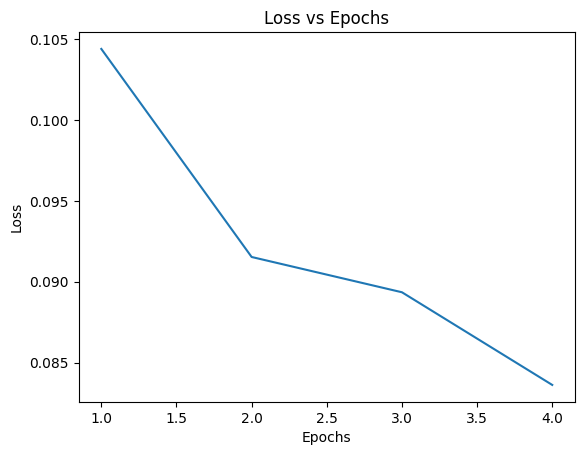

In [ ]:
plt.plot([i for i in range(1,len(epoch_losses)+1)],epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

In [ ]:
target_sentence='a young boy fell into a pool of water'
for word in [tok.text.lower() for tok in spacy_eng.tokenizer(target_sentence)]:
  if word in dataset.vocab.stoi_target.keys(): print('1',end=' ')
  else: print('0',end=' ')
print()
source_inp='Guten Abend'
for word in [tok.text.lower() for tok in spacy_ger.tokenizer(source_inp)]:
  if word in dataset.vocab.stoi_source.keys(): print('1',end=' ')
  else: print('0',end=' ')

1 1 1 1 1 1 1 1 1 
0 0 

In [ ]:
source_word_idxs=[dataset.vocab.stoi_source['<SOS>'],]
for word in [tok.text.lower() for tok in spacy_ger.tokenizer(source_inp)]:
  #print(f'word: {word}')
  if word in dataset.vocab.stoi_source.keys():
    source_word_idxs.append(dataset.vocab.stoi_source[word])
  else:
    source_word_idxs.append(dataset.vocab.stoi_source['<UNK>'])
source_word_idxs.append(dataset.vocab.stoi_source['<EOS>'])
source_word_idxs=torch.tensor(source_word_idxs)

translated_sentence=model.translate(source_word_idxs,dataset.vocab.itos_target,device)
print(f'Target sentence: {target_sentence}')
print(f'Translated sentence: {translated_sentence}')

Target sentence: a young boy fell into a pool of water
Translated sentence: <SOS> a <UNK> is being and an orange country smiling to another stand up <UNK> <UNK> <EOS>


In [ ]:
dataset.vocab.stoi_source['baden']

1462

In [ ]:
'sprang' in dataset.vocab.itos_source.values()

False

In [ ]:
dataset.vocab.itos_source

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: 'männer',
 5: 'im',
 6: 'ein',
 7: 'mann',
 8: 'eines',
 9: 'eine',
 10: 'auf',
 11: 'zwei',
 12: 'die',
 13: 'mädchen',
 14: 'springen',
 15: 'der',
 16: 'einem',
 17: 'frau',
 18: 'mit',
 19: 'das',
 20: 'einer',
 21: 'und',
 22: 'sitzt',
 23: 'etwas',
 24: 'beim',
 25: 'spielen',
 26: 'hält',
 27: 'einen',
 28: 'steht',
 29: 'vor',
 30: 'den',
 31: 'mehrere',
 32: 'menschen',
 33: 'bei',
 34: 'hund',
 35: 'junge',
 36: 'fährt',
 37: 'stehen',
 38: 'in',
 39: 'am',
 40: 'platz',
 41: 'auto',
 42: 'fahrrad',
 43: 'schaut',
 44: '2',
 45: 'sitzen',
 46: 'über',
 47: 'personen',
 48: 'sich',
 49: 'aus',
 50: 'klettert',
 51: 'an',
 52: 'straße',
 53: 'kinder',
 54: 'dem',
 55: 'kleiner',
 56: 'kamera',
 57: 'führt',
 58: 'schnee',
 59: 'gruppe',
 60: 'von',
 61: 'mannes',
 62: 'hoch',
 63: 'springt',
 64: 'kind',
 65: 'spielt',
 66: 'durch',
 67: 'ball',
 68: 'zu',
 69: 'davor',
 70: 'paar',
 71: 'baum',
 72: 'hunde',
 73: 'strand'